In [160]:
import numpy as np
import gensim
import nltk
from sklearn.decomposition import PCA
from matplotlib import pyplot

# Tasks 
(Python Solution to get an overview of the problem)
1. Extract the Embeddings of Documents & Query efficiently (In-/Out-Embeddings > 5GB each!)
2. Visualize the document-query embedding space
3. Compute DESM-Score and evaluate with experiment of Paper A Dual Embedding Space Model for Document Ranking (Table 2 in paper)

### Dependencies
1. word embeddings (in.txt, out.txt) need to be in same directory

# Extract Embeddings

In [161]:
open('data.txt').read().split('\n\n')[0]

'The city of Cambridge is a university city and the county town of Cambridgeshire, England.  It lies\nin East Anglia, on the River Cam, about 50 miles (80 km) north of London. According to the United\nKingdom Census 2011, its population was 123,867 (including 24,488 students). This makes Cambridge\nthe second largest city in Cambridgeshire after Peterborough, and the 54th largest in the United Kingdom.\nThere is archaeological evidence of settlement in the area during the Bronze Age and Roman times;\nunder Viking rule Cambridge became an important trading centre. The first town charters were granted\nin the 12th century, although city status was not conferred until 1951.'

In [162]:
#Tokenize Documents (documents are seperated by \n\n and ended with \n\n\n)
def tokenize_docs(path, amountDocs):
    #get documents (as a string) into a list
    f = open(path)
    docs = f.read().split('\n\n')[:amountDocs]
    f.close()
    #Tokenize documents
    tokenizer = nltk.tokenize.RegexpTokenizer(r'\w+')
    doc_list = []
    for idx, doc in enumerate(docs):
        doc = doc.lower()
        doc_list.append(tokenizer.tokenize(doc))
    #format numbers correctly for each document
    list_numb = []
    next_numb = False
    for doc in doc_list:
        numb = []
        for idx, word in enumerate(doc):
            if idx<len(doc)-1 and doc[idx].isdigit() and doc[idx+1].isdigit():
                numb.append(doc[idx] + '.' + doc[idx+1])
                next_numb = True
            elif next_numb:
                next_numb = False
                continue
            else:
                numb.append(word)
        list_numb.append(numb)
    return list_numb #doc_list

In [163]:
documents = tokenize_docs('data.txt', 5)

In [164]:
#build an offset index for each word in the embedding-file
def build_embed_index(path):
    f = open(path)
    d = dict()
    offset = 0
    for idx, word in enumerate(f):
        if idx%1000000==0:
            print('Progress: Line ' + str(idx))
        d[word.split('\t')[0]] = offset
        offset += len(word)+1
    f.close()
    return d

In [165]:
in_dic = build_embed_index('in.txt')
out_dic = build_embed_index('out.txt')

Progress: Line 0
Progress: Line 1000000
Progress: Line 2000000
Progress: Line 0
Progress: Line 1000000
Progress: Line 2000000


In [166]:
f = open('in.txt')
f.seek(0)
f.seek(in_dic['the'])
w = f.readline()
print(w.split('\t')[0], [float(i) for i in w.split('\t')[1:]])
f.close()

the [0.020954, -0.006632, -0.103103, 0.08206, 0.003313, 0.036865, -0.018602, -0.020235, -0.100809, 0.00888, -0.045356, -0.058931, -0.037689, 0.024242, 0.082323, -0.015734, -0.140314, 0.062658, 0.036014, 0.118489, 0.059976, 0.055213, 0.065356, 0.057408, 0.087332, -0.008574, 0.10927, -0.117298, 0.10422, 0.07505, 0.048633, -0.056942, 0.047313, 0.014587, 0.004798, -0.016378, 0.000893, -0.035273, 0.065086, 0.081557, -0.011301, -0.103547, -0.140496, -0.115079, -0.051609, 0.020947, -0.09124, 0.036975, 0.131189, 0.042397, -0.028097, -0.054932, -0.051236, 0.033599, -0.009727, 0.01122, 0.029692, 0.010664, 0.020816, 0.054101, -0.005857, -0.05388, -0.015685, 0.001653, 0.03097, -0.05072, 0.022598, 0.106003, 0.024549, 0.035735, 0.043685, -0.03783, 0.096765, -0.001681, -0.020546, -0.072955, -0.036875, 0.020559, 0.062735, -0.077124, 0.150957, -0.06671, -0.01855, -0.021941, -0.003186, -0.025571, -0.076848, -0.136842, -0.001924, 0.017544, 0.05541, -0.014795, 0.08681, -0.052711, -0.03141, -0.092883, 0.04

In [167]:
#extract the word embeddings per document
def extract_embed(file, dic, doc):
    fd = open(file)
    vecs = []
    for word in doc:
        if word not in dic.keys():
            continue
            #vecs.append(np.zeros(200))
        else:
            fd.seek(dic[word])
            w = fd.readline()
            vecs.append(np.array([float(i) for i in w.split('\t')[1:]]))
    fd.close()
    return vecs

In [168]:
#Get word embeddings for each document, resulting Data Structure: doc_embeds[doc][vec][item]
doc_embeds = []
for document in documents:
    doc_embeds.append(extract_embed('out.txt', out_dic, document))
len(doc_embeds[0][0])

200

In [169]:
#Get word embeddings for the query, resulting Data Structure: query_embeds[query][vec][item]
query = ['cambridge']
query_embeds = []
query_embeds.append(extract_embed('in.txt', in_dic, query))
len(query_embeds[0][0])

200

In [170]:
#Using gensim to load the word embeddings doesn't seem to work because of formating (also the files are really big)
# =>correct formating is another approach to try!
#wordvecs = gensim.models.KeyedVectors.load_word2vec_format('in.txt', binary=False)

# Visualize document-query embedding space

## How to represent a Document D with word embeddings
Here D is the centroid of all the normalized vectors for the words in the document serving as a single embedding for the whole document

## How to compute a centroid of word embeddings
To find the centroid, one computes the (arithmetic) mean of the points' positions separately for each dimension.

## Computing a Documents-Query Representation with PCA
A  two  dimensional  PCA  projection  of  the  200-
dimensional embeddings. Relevant documents are yellow, irrel-
evant documents are grey, and the query is blue.  To visualize
the  results  of  multiple  queries  at  once,  before  dimensionality
reduction we centre query vectors at the origin and represent
documents as the difference between the document vector and
its query vector.

In [171]:
#Compute Document-Centroid

def euclid_norm(v):
    norm = 0
    for i in v:
        norm += i**2
    return np.sqrt(norm)

def abs_norm(v):
    norm = 0
    for i in v:
        norm += abs(i)
    return norm

def compute_centroid(D):
    D_N = len(D)
    centroid = np.zeros(len(D[0]))
    for d in D:
        centroid += d / euclid_norm(d)
    return centroid/D_N

In [172]:
doc_centroids = []
for embed in doc_embeds:
    doc_centroids.append(compute_centroid(embed))
len(doc_centroids[0])

200

In [173]:
pca = PCA(n_components=2)

In [174]:
doc_pca = pca.fit_transform(doc_centroids + query_embeds[0])

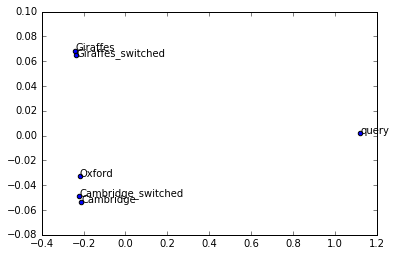

In [175]:
pyplot.scatter(list(doc_pca[:, 0]), list(doc_pca[:, 1]))
doc_title = ['Cambridge', 'Oxford', 'Giraffes', 'Giraffes_switched', 'Cambridge_switched', 'query']
for idx, doc in enumerate(doc_title):
    pyplot.annotate(doc, xy=(doc_pca[idx,0], doc_pca[idx,1]))
pyplot.show()

## Compute DESM

In [176]:
#Function to compute desm for a query and all documents
def desm(Q, D):
    #Denominator
    Q_N = len(Q)
    #Sum of cosine similarities between query term and document
    Q_cosine = 0
    for q in Q:
        Q_cosine += q.dot(D) / euclid_norm(q) * euclid_norm(D)
    return Q_cosine/Q_N

In [177]:
def sort_help(elem):
    return elem[1]
ranking = [(doc_title[idx], desm(query_embeds[0], doc_centroids[idx])) for idx in range(len(doc_centroids))]

ranking.sort(key=sort_help, reverse=True)
ranking

[('Cambridge', -0.05113931496738447),
 ('Oxford', -0.05702753890771936),
 ('Cambridge_switched', -0.06067280038670073),
 ('Giraffes_switched', -0.07643237307293758),
 ('Giraffes', -0.0825272178554687)]